## Analysis - Housing Price Prediction using Zillow Data

In [183]:
# Importing what we need 
import numpy as np 
e = np.e
import pandas as pd 
import matplotlib
import statsmodels.api as sm 
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

## Read the dataset

In [184]:
# Read the data
df = pd.read_csv("../resources/data/metro_zillow.csv", nrows=1000)

# Taking a look at the shape of the dataset
print(df.shape)

# This line will tell us how many of our rows represent metro areas
print(df.RegionType.value_counts())

# Examining the first five rows of our dataframe
df.head()

(928, 87)
RegionType
msa        927
country      1
Name: count, dtype: int64


,RegionID,SizeRank,RegionName,RegionType,StateName,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,...,3/31/2024,4/30/2024,5/31/2024,6/30/2024,7/31/2024,8/31/2024,9/30/2024,10/31/2024,11/30/2024,12/31/2024
0,394327,139,"Anchorage, AK",msa,AK,298332.0,308298.0,316383.0,321350.0,319717.0,...,414483.0,430152.0,438819.0,443502,441333.0,441000.0,438000.0,434667,429817.0,428150.0
1,394580,407,"Fairbanks, AK",msa,AK,221183.0,229100.0,236467.0,245533.0,247200.0,...,324200.0,330933.0,337600.0,345083,343450.0,331783.0,323267.0,321600,328267.0,331600.0
2,394730,802,"Juneau, AK",msa,AK,386817.0,380983.0,378567.0,379317.0,388817.0,...,510833.0,548167.0,555000.0,553333,545833.0,560833.0,560833.0,563333,544167.0,529167.0
3,394743,936,"Ketchikan, AK",msa,AK,324500.0,327833.0,333000.0,344500.0,358167.0,...,441667.0,441000.0,459667.0,455167,462167.0,453833.0,457333.0,453000,452667.0,454500.0
4,394388,51,"Birmingham, AL",msa,AL,209267.0,218967.0,225633.0,229600.0,229900.0,...,276633.0,281709.0,290009.0,296643,299833.0,299533.0,299467.0,296900,293867.0,287157.0


The raw dataframe contains 928 rows and 87 columns. Among these columns, five provide details about the metro area associated with each row. Columns 6 through 82 represent a time series spanning from March 2018 to December 2024, with values indicating the median home price for that metro area in each specific month.

Notably, out of the 928 rows, the last row is unique in that it does not correspond to a specific metro area. Instead, it tracks the median home price for the entire United States.

## Investing in California
* For an investment in California, we need to filter down our dataset to metro areas in CA

In [187]:
# Making a dataframe of just California data
df_ca = df[df['StateName'] == 'CA']

# Seeing how many rows we get 
print(df_ca.shape)

# Sanity check 
df_ca.head()

(34, 87)


,RegionID,SizeRank,RegionName,RegionType,StateName,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,...,3/31/2024,4/30/2024,5/31/2024,6/30/2024,7/31/2024,8/31/2024,9/30/2024,10/31/2024,11/30/2024,12/31/2024
61,753899,2,"Los Angeles, CA",msa,CA,778333.0,791667.0,799667.0,806300.0,805967.0,...,1041633.0,1075000.0,1108000.0,1133000,1149333.0,1133000.0,1116333.0,1099967,1091633.0,1067967.0
62,395057,12,"San Francisco, CA",msa,CA,895731.0,946083.0,978000.0,989667.0,972667.0,...,1163333.0,1198000.0,1211333.0,1211000,1194667.0,1166000.0,1163000.0,1166300,1148300.0,1084300.0
63,395025,13,"Riverside, CA",msa,CA,389967.0,394933.0,398267.0,399900.0,399767.0,...,593667.0,597967.0,599633.0,600823,600823.0,600490.0,599300.0,599000,599000.0,599000.0
64,395056,17,"San Diego, CA",msa,CA,702667.0,715000.0,721633.0,727967.0,724633.0,...,955300.0,973817.0,990150.0,997667,991333.0,986667.0,978000.0,967667,955667.0,949000.0
65,395045,26,"Sacramento, CA",msa,CA,442633.0,454300.0,458300.0,461333.0,456333.0,...,621612.0,632696.0,642417.0,649417,649667.0,646300.0,641300.0,634967,628000.0,621333.0


* So after filtering our dataframe down, we are left with 34 metro areas throughout California.

## Checking for NaN values

In [188]:
# Checking our dataframe for NaN values
print(f'There are {df_ca.isna().sum().sum()} NaNs in our original dataframe')

# Backfilling that single NaN
df_ca.fillna(method='bfill', inplace=True)

# Sanity check
print(f'There are {df_ca.isna().sum().sum()} NaNs after using backfill')

There are 8 NaNs in our original dataframe
There are 0 NaNs after using backfill


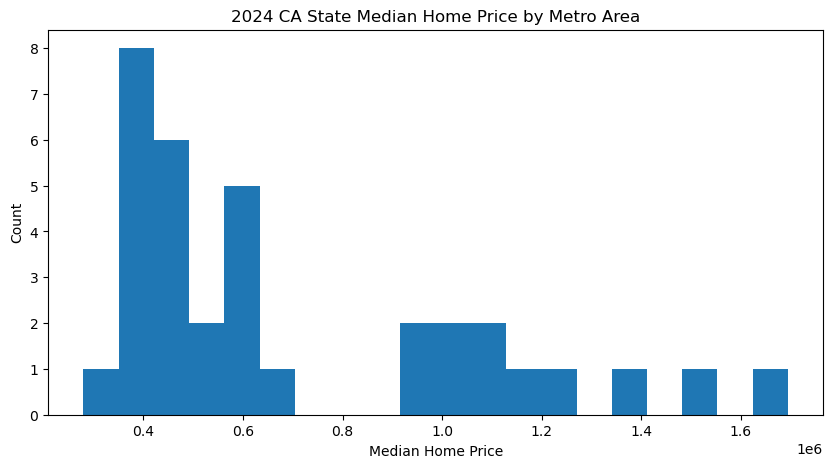

In [191]:
#Price distribution within Michigan
# Getting a list of the values for the last date in our time series
current_median_msa_home_prices = list(df_ca['12/31/2024'])

# Plotting the results
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(current_median_msa_home_prices, bins=20)
plt.title('2024 CA State Median Home Price by Metro Area')
plt.xlabel('Median Home Price')
plt.ylabel('Count')
plt.show()

* We have a few outliers, some of which are Santa Maria and Salinas area, as confirmed below. However, this doesn't necessarily imply that they are the best or worst investment choice, despite what our models may suggest.

In [192]:
# Checking the median home price for Ann Arbor in the most recent month. 
int(df_ca[df_ca['RegionName'] == 'Salinas, CA']['12/31/2024'])

1185750

## Melt Data Function

In [193]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

## Time Series for California

Text(0, 0.5, 'Averaged Median Home Price')

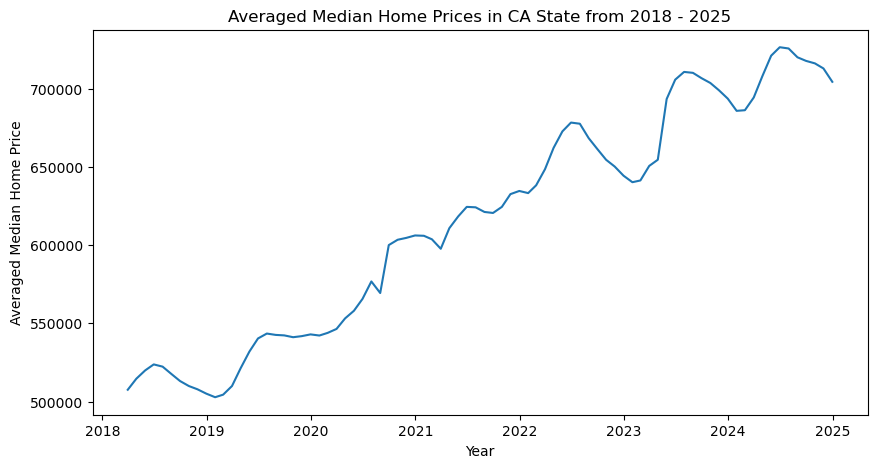

In [ ]:
# Melting the California dataframe
df_ca_melted = melt_data(df_ca)

# Plotting the average time series for all of CA state
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(df_ca_melted)
plt.title('Averaged Median Home Prices in CA State from 2018 - 2025')
plt.xlabel('Year')
plt.ylabel('Averaged Median Home Price')

## Reshaping the Dataframe

In [196]:
# Reshaping the dataframe
df_reshaped = pd.DataFrame()
for i in df_ca['RegionName']:
    x = melt_data(df_ca[df_ca['RegionName'] == i])
    df_reshaped = pd.concat([df_reshaped, x], axis=1)
    df_reshaped.rename(columns = {'value':i}, inplace = True)
    
df_reshaped.head()

,"Los Angeles, CA","San Francisco, CA","Riverside, CA","San Diego, CA","Sacramento, CA","San Jose, CA","Fresno, CA","Bakersfield, CA","Oxnard, CA","Stockton, CA",...,"Hanford, CA","Napa, CA","Eureka, CA","Truckee, CA","Ukiah, CA","Clearlake, CA","Red Bluff, CA","Sonora, CA","Susanville, CA","Crescent City, CA"
time,,,,,,,,,,,,,,,,,,,,,
2018-03-31,778333.0,895731.0,389967.0,702667.0,442633.0,1199456.0,296167.0,256633.0,751450.0,378000.0,...,248217.0,808333.0,395483.0,545667.0,559951.0,299300.0,266617.0,317967.0,236650.0,284917.0
2018-04-30,791667.0,946083.0,394933.0,715000.0,454300.0,1239086.0,297857.0,261800.0,751450.0,378333.0,...,250483.0,842333.0,395483.0,539333.0,548284.0,305000.0,273317.0,329650.0,230667.0,290250.0
2018-05-31,799667.0,978000.0,398267.0,721633.0,458300.0,1269094.0,302823.0,266133.0,751600.0,380000.0,...,252483.0,902333.0,393483.0,531333.0,552303.0,311667.0,279158.0,336317.0,209943.0,293000.0
2018-06-30,806300.0,989667.0,399900.0,727967.0,461333.0,1269613.0,306657.0,267467.0,749433.0,385000.0,...,253567.0,922333.0,394333.0,526667.0,567333.0,325000.0,277492.0,342983.0,206795.0,291167.0
2018-07-31,805967.0,972667.0,399767.0,724633.0,456333.0,1263317.0,309966.0,268667.0,749467.0,390000.0,...,254383.0,913000.0,392000.0,519833.0,583667.0,326000.0,275492.0,344333.0,213461.0,287833.0


# Time Series Length
* A key characteristic of our raw dataset must be addressed: Like the rest of the U.S., California experienced a sharp decline in home sales in 2021. If we train our models on the entire dataset, they may be disproportionately influenced pre-2020, sub 3% interest rates, which could impact their predictive accuracy—especially since our business use case focuses on forecasting just one year ahead.

* To prevent this from compromising model performance in validation tests and future predictions, we will limit our training data to only include data from March 2018 onward.

In [197]:
# Reshape to make sure we train our model from Mar 2018 and beyond
df_2018 = df_reshaped['2018-03-31':]

# Examining the new shape
print(df_2018.shape)

# Sanity check
df_2018.head()

(82, 34)


,"Los Angeles, CA","San Francisco, CA","Riverside, CA","San Diego, CA","Sacramento, CA","San Jose, CA","Fresno, CA","Bakersfield, CA","Oxnard, CA","Stockton, CA",...,"Hanford, CA","Napa, CA","Eureka, CA","Truckee, CA","Ukiah, CA","Clearlake, CA","Red Bluff, CA","Sonora, CA","Susanville, CA","Crescent City, CA"
time,,,,,,,,,,,,,,,,,,,,,
2018-03-31,778333.0,895731.0,389967.0,702667.0,442633.0,1199456.0,296167.0,256633.0,751450.0,378000.0,...,248217.0,808333.0,395483.0,545667.0,559951.0,299300.0,266617.0,317967.0,236650.0,284917.0
2018-04-30,791667.0,946083.0,394933.0,715000.0,454300.0,1239086.0,297857.0,261800.0,751450.0,378333.0,...,250483.0,842333.0,395483.0,539333.0,548284.0,305000.0,273317.0,329650.0,230667.0,290250.0
2018-05-31,799667.0,978000.0,398267.0,721633.0,458300.0,1269094.0,302823.0,266133.0,751600.0,380000.0,...,252483.0,902333.0,393483.0,531333.0,552303.0,311667.0,279158.0,336317.0,209943.0,293000.0
2018-06-30,806300.0,989667.0,399900.0,727967.0,461333.0,1269613.0,306657.0,267467.0,749433.0,385000.0,...,253567.0,922333.0,394333.0,526667.0,567333.0,325000.0,277492.0,342983.0,206795.0,291167.0
2018-07-31,805967.0,972667.0,399767.0,724633.0,456333.0,1263317.0,309966.0,268667.0,749467.0,390000.0,...,254383.0,913000.0,392000.0,519833.0,583667.0,326000.0,275492.0,344333.0,213461.0,287833.0


In [ ]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

In [214]:
check_stationarity(df_2018['Los Angeles, CA'])

ADF Statistic: -0.6767289537979833
p-value: 0.8526855399082687
Non-Stationary


## Train Test Split

* To validate our models and assess their effectiveness, we need to split our time series data into a training set and a test set. In a time series context, the training set will consist of the first 80% of the data, while the test set will cover the remaining 20%. Since our post-March 2018 data spans 6.92 years, this results in a training period of 5.25 years and a test period of 1.67 years.

* This training-to-test ratio strengthens the justification for our predictions. If our models can accurately forecast values 2 years ahead based on 6.92 years of data, we can be more confident in their ability to predict values one year ahead using a larger dataset.

In [198]:
# Printing out the lengths of our unsplit time series 
print(f'Whole series lengths: {len(df_2018)} \n')

# Manually dividing the data into train and test sets
train = df_2018[:'2023-05-31']
test = df_2018['2023-05-31':]

# Printing the lengths of our new train and test sets
print(f'Train set lengths: {len(train)}')
print(f'Test set lengths: {len(test)} \n')

# Checking that the proportions are how we want them 
print(f'Train proportion = {round(len(train) / len(df_2018),1)}')
print(f'Test proportion = {round(len(test) / len(df_2018),1)} \n')

# Checking the length in years of our train and test sets
print(f'Train set length in years: {round(len(train) / 12, 2)}')
print(f'Test set length in years: {round(len(test) / 12, 2)}')

Whole series lengths: 82 

Train set lengths: 63
Test set lengths: 20 

Train proportion = 0.8
Test proportion = 0.2 

Train set length in years: 5.25
Test set length in years: 1.67


## Setting a Performance Benchmark Before Model Training
* To assess whether modeling will provide value in this business context, we will compare our models' performance against a simple, exploratory data analysis approach.

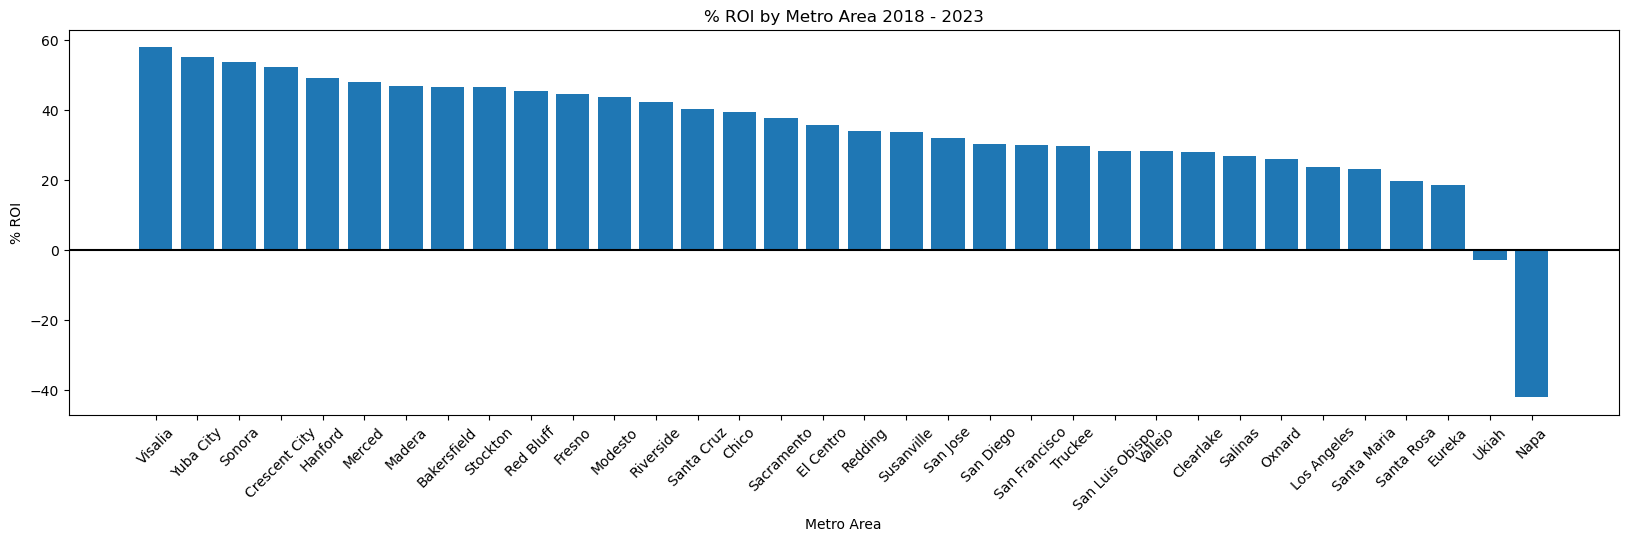

,% ROI
City,
Visalia,57.80
Yuba City,55.12
Sonora,53.61
Crescent City,52.24
Hanford,49.18


In [199]:
# Establishing a Performance Baseline Before Modeling
# These lists will hold the names of each metro area, as well as that area's ROI from 2012 to 2021
names = []
historical_roi = []

# This for loop adds the information to the two lists
for i in range(len(train.columns)):
    
    clean_name = train.columns[i][:-4]
    
    initial_val = train[train.columns[i]]['2018-03-31']
    present_val = train[train.columns[i]]['2023-04-30']
    
    roi = round(((present_val - initial_val) / initial_val) * 100, 2)
    
    names.append(clean_name)
    historical_roi.append(roi)

# Turning the data into a pandas dataframe
roi_df = pd.DataFrame()
roi_df['City'] = names
roi_df['% ROI'] = historical_roi
roi_df.sort_values(['% ROI'], inplace=True, ascending=False)
roi_df.set_index('City', inplace=True)

# Plotting the historical data 
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(roi_df.index, roi_df['% ROI'])
plt.title('% ROI by Metro Area 2018 - 2023')
plt.xlabel('Metro Area')
plt.ylabel('% ROI')
plt.xticks(rotation=45)
plt.axhline(0, color='k')
plt.show()

# Displaying our top five choices based on EDA
roi_df.head()

In [200]:
# Our top five choices based on EDA results
top_5 = ['Visalia, CA', 'Yuba City, CA', 'Sonora, CA', 'Crescent City, CA', 'Hanford, CA']

# These two lists will track our buy and sell numbers
buys = []
sells = []

# Getting the median values for 2023 (buys) and 2024 (sells)
for i in top_5:
    buys.append(df_2018[i]['2023-04-30'])
    sells.append(df_2018[i]['2024-12-31'])

# Calculating the ROI we would have achieved
eda_roi = round( ((sum(sells) - sum(buys)) / sum(buys) ) * 100, 2)

# Printing the ROI
print(f'Using an EDA approach, we could have achieved {eda_roi}% ROI from 2023 to 2024')

Using an EDA approach, we could have achieved -0.26% ROI from 2023 to 2024


## Modeling
* Preparing the functions - Since our goal is to identify the five most optimal metro areas for investment within California, we need to run time series models for each metro area individually. Given that there are 34 metro areas, doing this manually is impractical, so we are automating the process by writing functions to handle these steps efficiently.

In [182]:
def log_transform(series_i):
    
    '''Takes in a series and returns the log transformed version of that series'''
    
    log_transformed = np.log(series_i)
    dropped_nans = log_transformed.dropna()
    return dropped_nans

In [111]:
def run_auto_arima(series_i):
    
    '''ARIMA (Autoregressive Integrated Moving Average) is specifically designed to model time 
    series data, meaning it analyzes patterns within a sequence of data points ordered by time, 
    allowing prediction of future values based on past trends. 
    Runs a grid search on the series passed in, then instantiates and fits 
    an ARIMA model with those hyperparameters, then returns that fit model. '''
    
    gridsearch = auto_arima(series_i,
                            start_p = 0,
                            max_p = 3,
                            d = 0, 
                            max_d = 3, 
                            start_q = 0,
                            max_q = 3,
                            seasonal=True,
                            m = 12,
                            suppress_warnings=True)
    
    model = ARIMA(series_i, 
                  order = gridsearch.order, 
                  seasonal_order = gridsearch.seasonal_order,
                  enforce_stationarity=False)
    
    return model.fit()

In [112]:
def run_arima_model(i, steps, df):
    
    '''This function takes i, representing the index of one of our time series,
    steps, which is the number of periods after the end of the 
    sample you want to make a prediction for, and df, the dataframe the series
    is stored in. It log transforms the series, runs run_auto_arima, gets the 
    forecast from the fit model, and inverse log transforms that forecast series
    back into the original units.'''
    
    series = df.iloc[:, i:i+1]
    
    name = series.columns[0]
    
    log_series = log_transform(series)
    
    model = run_auto_arima(log_series)

    log_forecast = model.get_forecast(steps)
    forecast_series = e ** log_forecast.summary_frame()
    
    return name, series, forecast_series

In [113]:
def plot_results(i, steps, df):
    
    '''plot_results runs run_arima_model() and plots the results.'''
    
    name, original_series, forecast_series = run_arima_model(i, steps, df)

    fig, ax = plt.subplots(figsize=(15, 7))
    plt.plot(original_series)
    plt.plot(forecast_series['mean'])
    ax.fill_between(forecast_series.index, forecast_series['mean_ci_lower'], 
                    forecast_series['mean_ci_upper'], color='k', alpha=0.1)
    plt.title(name)
    plt.legend(['Original','Predicted'], loc='lower right')
    plt.xlabel('Year')
    plt.ylabel('Median Home Price')
    plt.show()
    
    forecast = round(forecast_series['mean'][11])
    low_int =  round(forecast_series['mean_ci_lower'][11])
    high_int = round(forecast_series['mean_ci_upper'][11])
    
    print(f'12 month forecast: {forecast}')
    print(f'95% confidence that the true future value is between {low_int}, and {high_int}')

In [166]:
def evaluate_models(df1, df2):
    
    '''This function takes in two dataframes (train and test in our case), 
    and returns a dataframe with how accurate the models fit to the train 
    set were in predicting the test set values.'''

    names = []
    actuals = []
    preds = []
    perc_errors = []
    
    for i in range(len(train.columns)):
        
        name, series, forecast_series = run_arima_model(i, 24, df1)
        
        clean_name = name[:-4]
        
        actual_val = df2[name][-1]
        predicted_val = forecast_series.iloc[23, 0]
        error = abs(actual_val - predicted_val)
        percent_error = (error/ actual_val) * 100
        
        names.append(clean_name)
        actuals.append(f'{round(actual_val):,}')
        preds.append(f'{round(predicted_val):,}')
        perc_errors.append(round(percent_error, 2))
        
        #print(train.columns[i][:-4], 'done', f'{i+1}/26')
        
    
    results_df = pd.DataFrame(index=names)
    results_df['2024 Actual'] = actuals 
    results_df['2024 Predicted'] = preds
    results_df['% Error'] = perc_errors
    results_df.sort_values(by='% Error', inplace=True)
    
    return results_df

In [115]:
def generate_predictions(df, steps):
    
    '''Similar to evaluate_models(), this function takes in a dataframe,
    and a specific number of steps, and returns a dataframe of the 
    future predictions the specified number of steps past the end of 
    the sample.'''
    
    names = []
    current_vals = []
    pred_vals = []
    net_profits = []
    ROI_strings = []
    
    count = 0
    for i in range(len(df.columns)):
        
        count += 1
        
        name, series, forecast = run_arima_model(i, steps, df)
        
        clean_name = name[:-4]
        print(clean_name)
        
        cur_val = series.iloc[-1, 0]
        pred_val = forecast.iloc[steps-1, 0]
        net_prof = round(pred_val - cur_val , 2)
        roi = int(round(((pred_val - cur_val) / cur_val) * 100, 2))
        
        names.append(clean_name)
        current_vals.append(f'{round(cur_val):,}')
        pred_vals.append(f'{round(pred_val):,}')
        net_profits.append(f'{round(net_prof):,}')
        ROI_strings.append(f'{roi}%') 
        
        if count == 26:
            break
    
    
    results_df = pd.DataFrame()
    results_df['City'] = names
    results_df.set_index(['City'])
    results_df['Current Value'] = current_vals
    results_df['Predicted Value'] = pred_vals
    results_df['Net Profit'] = net_profits
    results_df['ROI'] = ROI_strings
    
    return results_df

## Model Evaluation
* To ensure our future predictions remain reasonably accurate, we will first assess how well our models perform on existing data. The evaluate_models() function will measure the difference between our model predictions for December 2024 and the actual observed values for that month.

* Since the models are trained only on data from 2018 to 2023, their predictions for December 2024 are made without any knowledge of the test data, which spans from 2023 to 2024. This approach helps validate their reliability in forecasting future trends.

In [201]:
# This dataframe will show us how accurate our models are 
eval_df = evaluate_models(train, test)

# Displaying the dataframe
eval_df

,2024 Actual,2024 Predicted,% Error
Crescent City,"452,000","450,676",0.29
Riverside,"599,000","601,468",0.41
Bakersfield,"383,300","380,818",0.65
San Diego,"949,000","933,076",1.68
Fresno,"453,333","445,122",1.81
Ukiah,"624,150","608,912",2.44
Vallejo,"596,000","578,831",2.88
Yuba City,"466,315","480,418",3.02
San Luis Obispo,"1,023,817","1,058,902",3.43
Sacramento,"621,333","649,600",4.55


In [202]:
eval_df = eval_df.iloc[:-1]
eval_df

,2024 Actual,2024 Predicted,% Error
Crescent City,"452,000","450,676",0.29
Riverside,"599,000","601,468",0.41
Bakersfield,"383,300","380,818",0.65
San Diego,"949,000","933,076",1.68
Fresno,"453,333","445,122",1.81
Ukiah,"624,150","608,912",2.44
Vallejo,"596,000","578,831",2.88
Yuba City,"466,315","480,418",3.02
San Luis Obispo,"1,023,817","1,058,902",3.43
Sacramento,"621,333","649,600",4.55


In [203]:
# Calculating the average error using the dataframe above 
average_error = str(round(sum([int(i) for i in eval_df['% Error']]) / len(eval_df) , 2)) + '%'

# Printing the result
print(f"On average our model based predictions were {average_error} off from the observed values.")

On average our model based predictions were 9.21% off from the observed values.


* On average, our model's predictions were about 9.21% off from the actual values in our test set. We are satisfied with these validation results, especially since we haven’t manually tuned any of the models.

* Moreover, this 9.21% average error comes from models trained on 5 years of data to predict two years ahead. In our final recommendations, we will use ten years of training data to predict just one year ahead. This suggests that our future predictions will likely be even more accurate than those in this validation test.

In [204]:
# Getting predictions from our models for December of 2024
model_predictions_2024 = generate_predictions(train, 24)

# Checking out the results
model_predictions_2024

Los Angeles
San Francisco
Riverside
San Diego
Sacramento
San Jose
Fresno
Bakersfield
Oxnard
Stockton
Modesto
Santa Rosa
Visalia
Vallejo
Santa Maria
Salinas
San Luis Obispo
Merced
Santa Cruz
Chico
Redding
El Centro
Yuba City
Madera
Hanford
Napa


,City,Current Value,Predicted Value,Net Profit,ROI
0,Los Angeles,"981,333","978,808","-2,525",0%
1,San Francisco,"1,214,667","1,184,730","-29,937",-2%
2,Riverside,"563,333","601,468","38,135",6%
3,San Diego,"932,633","933,076",443,0%
4,Sacramento,"620,983","649,600","28,617",4%
5,San Jose,"1,616,000","1,738,822","122,822",7%
6,Fresno,"430,267","445,122","14,855",3%
7,Bakersfield,"379,283","380,818","1,535",0%
8,Oxnard,"961,150","1,073,623","112,474",11%
9,Stockton,"559,629","641,045","81,416",14%


In [205]:
# A list of the top five metro areas output by our models
model_top_5 = ['Madera, CA', 'Santa Cruz, CA', 'Merced, CA', 'Hanford, CA', 'Stockton, CA']

# Variables to track initial and final investment value
buys = 0
sells = 0

# Adding the relevant values
for i in model_top_5:
    buys  += df_2018[i]['2023-04-30']
    sells += df_2018[i]['2024-12-31']

# Calculating the ROI
model_roi_2023 = round(((sells - buys) / buys) * 100 , 2)

# Displaying the results
print(f'Using modeling, we could have achieved {model_roi_2023}% ROI from 2023 to 2024')

Using modeling, we could have achieved -0.18% ROI from 2023 to 2024


* Switching from an EDA-based approach to modeling would have increased ROI from -0.26 % to -0.18 % between April 2023 and December 2024. This confirms that our modeling efforts are worthwhile and significantly impact this specific business outcome.

## Predictions
* The goal of this project is to give potential clients a starting point for investing in California real estate by identifying the five metro areas best suited for short-term investment. We have now reached the stage where we can make these predictions.

* Using the same modeling process as before, we will apply our models to the full 2018–2024 dataset to forecast the median home value for each of the 34 metro areas in December 2025. We will then rank these 26 growth estimates by highest projected ROI and select the top five as our final recommendations.

In [206]:
# Generating predictions one year past our entire 2018 to 2024 dataset
recommendation_df = generate_predictions(df_2018, 12)

# Looking at the results
recommendation_df.iloc[1:,:]

Los Angeles
San Francisco
Riverside
San Diego
Sacramento
San Jose
Fresno
Bakersfield
Oxnard
Stockton
Modesto
Santa Rosa
Visalia
Vallejo
Santa Maria
Salinas
San Luis Obispo
Merced
Santa Cruz
Chico
Redding
El Centro
Yuba City
Madera
Hanford
Napa


,City,Current Value,Predicted Value,Net Profit,ROI
1,San Francisco,"1,084,300","1,159,824","75,524",6%
2,Riverside,"599,000","629,602","30,602",5%
3,San Diego,"949,000","901,440","-47,560",-5%
4,Sacramento,"621,333","654,421","33,088",5%
5,San Jose,"1,545,315","1,590,688","45,373",2%
6,Fresno,"453,333","478,438","25,105",5%
7,Bakersfield,"383,300","392,942","9,642",2%
8,Oxnard,"992,000","1,002,199","10,199",1%
9,Stockton,"566,667","590,448","23,781",4%
10,Modesto,"508,316","515,574","7,258",1%


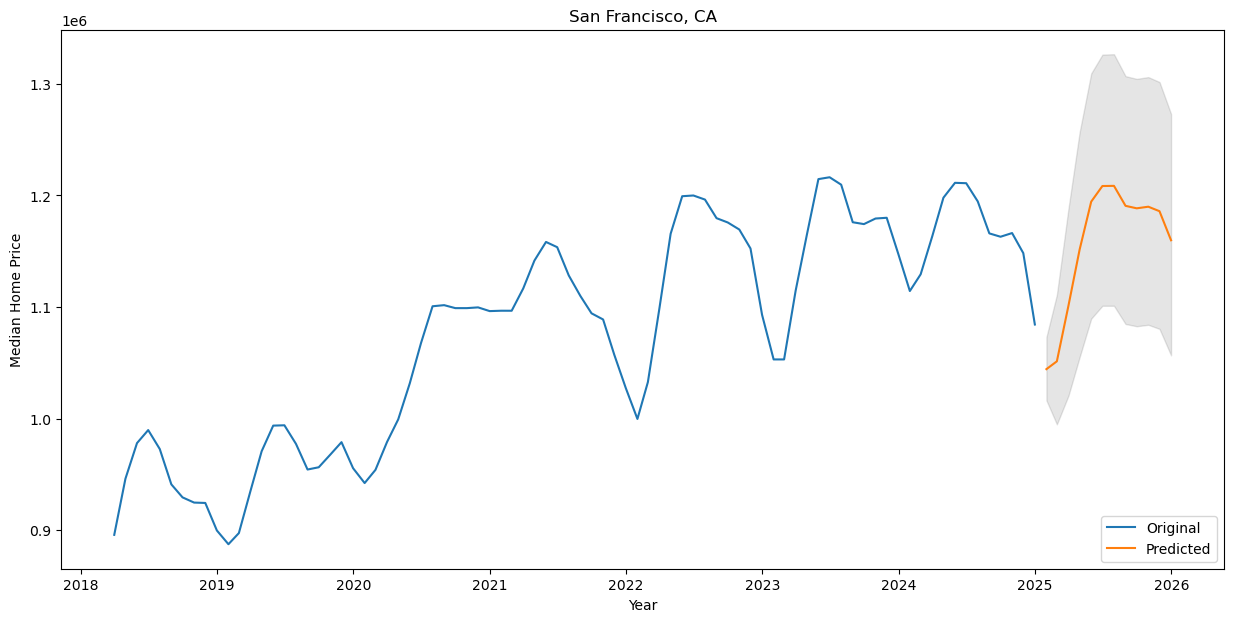

12 month forecast: 1159824
95% confidence that the true future value is between 1056634, and 1273092


In [207]:
plot_results(1, 12, df_2018)

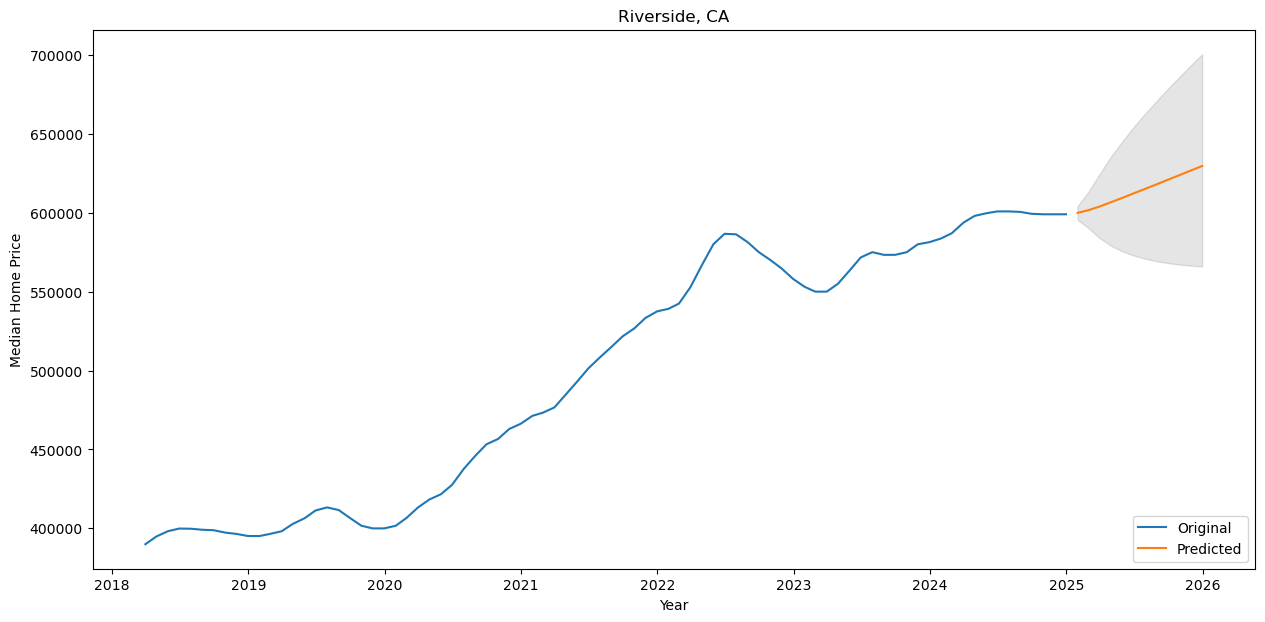

12 month forecast: 629602
95% confidence that the true future value is between 565954, and 700409


In [208]:
plot_results(2, 12, df_2018)

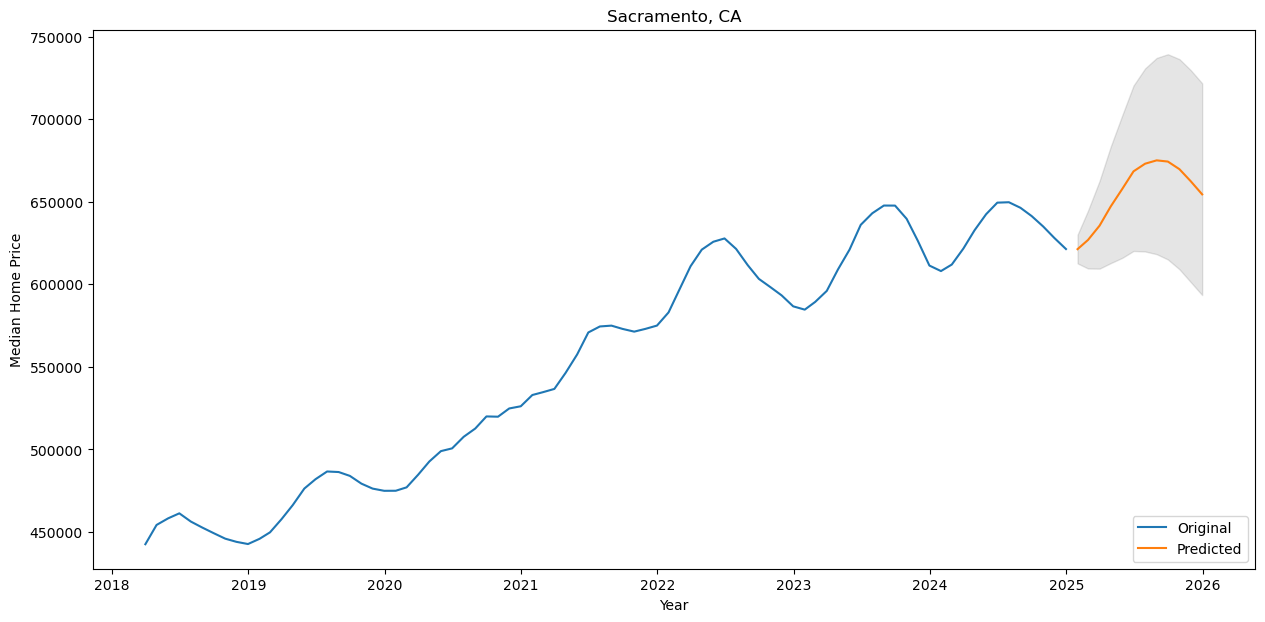

12 month forecast: 654421
95% confidence that the true future value is between 593451, and 721656


In [209]:
plot_results(4, 12, df_2018)

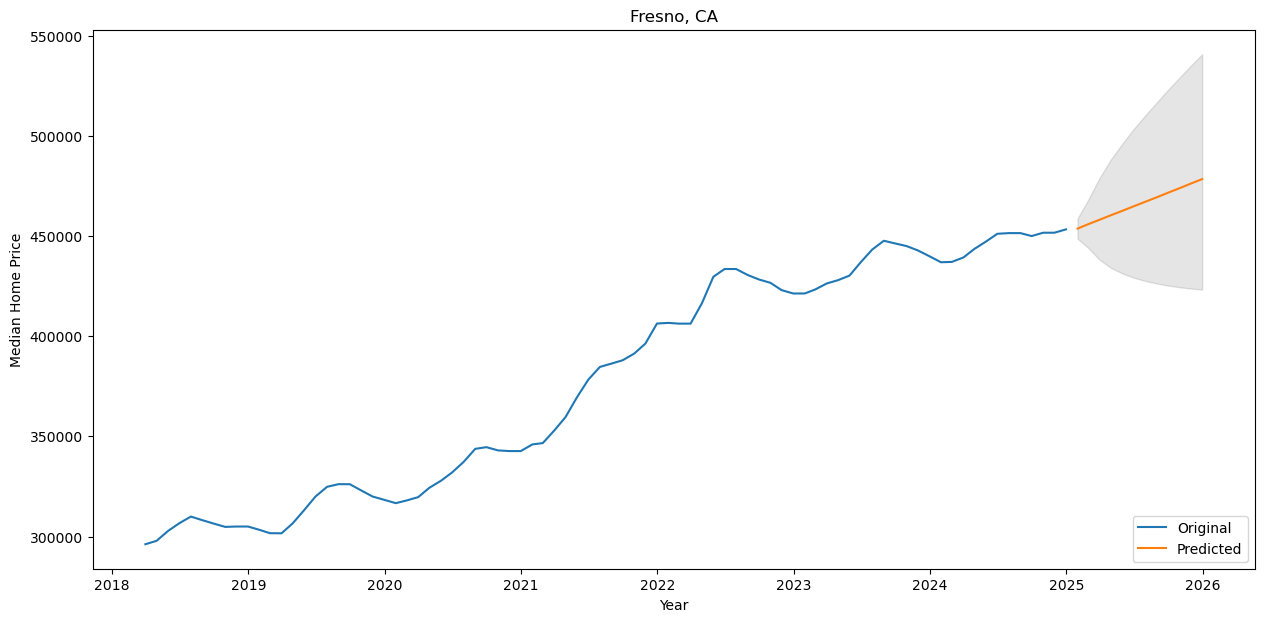

12 month forecast: 478438
95% confidence that the true future value is between 423294, and 540767


In [210]:
plot_results(6, 12, df_2018)

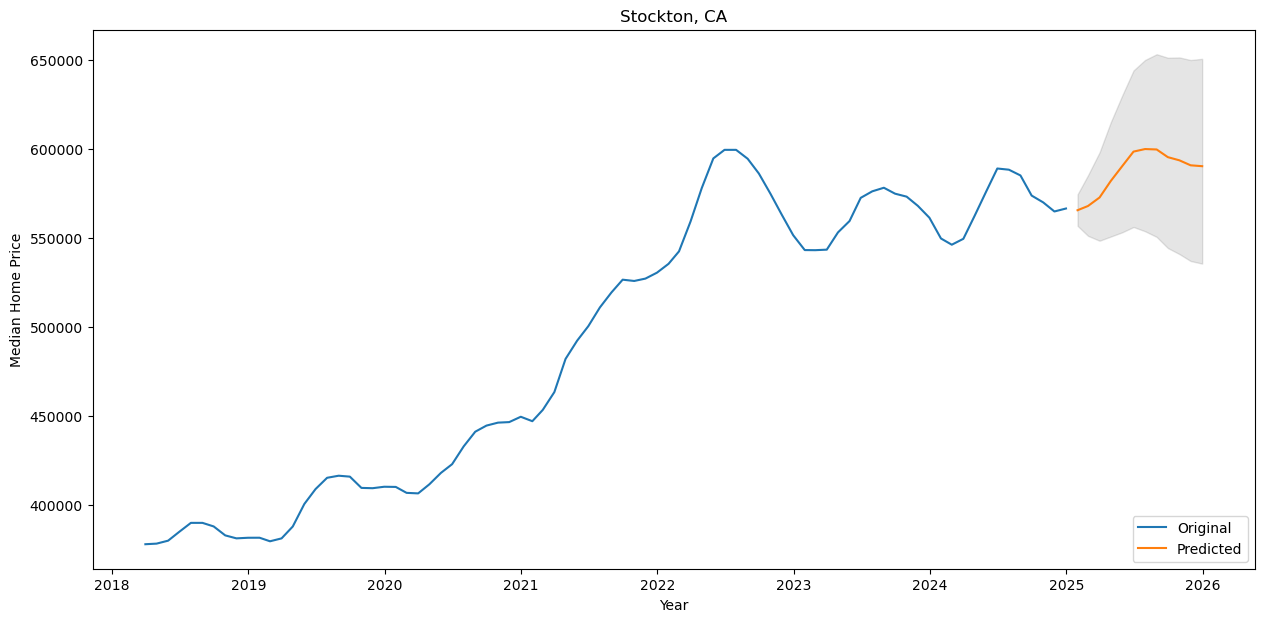

12 month forecast: 590448
95% confidence that the true future value is between 535696, and 650796


In [211]:
plot_results(9, 12, df_2018)